# Propensity Model

## Preliminary Code (Importing Libraries, Loading the Dataset)

In [1]:
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score
from imblearn.over_sampling import SMOTE


In [2]:
march_2024 = pd.read_parquet('../Data/Product Flags/cust_info_prod_202403_processed.parquet')
cust_info = pd.read_parquet('../Data/Other Data/CUSTOMER INFO.parquet')
merged_df = pd.merge(march_2024, cust_info, on='CUST_NUM', how='inner')
pd.set_option('display.max_columns', None)
merged_df = merged_df[merged_df['SUBSEGMENT'] == 'Top Tier']

merged_df

,CUST_NUM,IB,BUILDUP_F,CASH_MANAGEMENT,CORPORATE_LOANS,RETAIL_LOAN,TRADE_SERVICES,INVESTMENT_FUNDS,SECURITIES,INSURANCE,CORPORATE_FINANCE,FOREX,REMITTANCE,CORPORATE_CARDS,BB,DEPOSITS,RETAIL_PRODUCTS,INVESTMENTS_AND_SECURITIES,PROVINCE,REGION,EDUCATION,AGE,TENURE,BUSINESS_OWNER,DIGITAL_FLAG,INCOME_SOURCE,IDV_OR_ORG,SUBSEGMENT,GENDER,MARITAL_STATUS
5202,2996.230966,5.0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,NATIONAL CAPITAL REGION,NATIONAL CAPITAL REGION,NO_DATA,NaN,26.353425,N,TRADITIONAL,NO_DATA,ORG,Top Tier,MALE,SINGLE
5214,5771.552997,2.0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,NATIONAL CAPITAL REGION,NATIONAL CAPITAL REGION,NO_DATA,NaN,4.857534,N,TRADITIONAL,NO_DATA,ORG,Top Tier,FEMALE,SINGLE
5227,7757.409361,2.0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,NATIONAL CAPITAL REGION,NATIONAL CAPITAL REGION,NO_DATA,NaN,26.353425,N,TRADITIONAL,NO_DATA,ORG,Top Tier,MALE,SINGLE
5237,8908.145711,7.0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,NATIONAL CAPITAL REGION,NATIONAL CAPITAL REGION,NO_DATA,NaN,22.600000,N,TRADITIONAL,NO_DATA,ORG,Top Tier,MALE,SINGLE
5239,9108.712313,10.0,0,0,0,0,0,0,0,0,0,1,0,1,1,1,0,1,NATIONAL CAPITAL REGION,NATIONAL CAPITAL REGION,NO_DATA,NaN,23.194521,N,TRADITIONAL,NO_DATA,ORG,Top Tier,FEMALE,SINGLE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269957,12898.106838,5.0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,1,ZAMBOANGA DEL SUR,REGION IX (ZAMBOANGA PENINSULA),LOW,28.0,15.600000,N,DIGITAL,SALARY,INDIVIDUAL,Top Tier,FEMALE,SINGLE
278317,9932.948203,3.0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,ZAMBALES,REGION III (CENTRAL LUZON),MID,70.0,22.410959,N,DIGITAL,INTEREST_SAVINGS_PLACEMENTS_INVESTMENTS,INDIVIDUAL,Top Tier,MALE,SINGLE
287135,2438.565152,5.0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,SOUTH COTABATO,REGION XII (SOCCSKSARGEN),MID,80.0,26.353425,Y,TRADITIONAL,BUSINESS,INDIVIDUAL,Top Tier,FEMALE,DIVORCED
291548,11842.109609,2.0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,1,0,NEGROS ORIENTAL,REGION VII (CENTRAL VISAYAS),MID,45.0,22.410959,Y,DIGITAL,BUSINESS,INDIVIDUAL,Top Tier,FEMALE,MARRIED


## Data Cleaning

In [3]:
columns_to_keep = [
    'CUST_NUM', 'CORPORATE_LOANS', 'RETAIL_LOAN', 'TRADE_SERVICES', 'INVESTMENT_FUNDS',
    'SECURITIES', 'INSURANCE', 'CORPORATE_FINANCE', 'FOREX', 'REMITTANCE',
    'CORPORATE_CARDS', 'DEPOSITS', 'RETAIL_PRODUCTS', 'INVESTMENTS_AND_SECURITIES',
    'AGE', 'GENDER', 'MARITAL_STATUS', 'EDUCATION', 'INCOME_SOURCE',
    'BUSINESS_OWNER', 'PROVINCE', 'REGION', 'DIGITAL_FLAG', 'TENURE', 'SUBSEGMENT'
]

merged_df = merged_df[columns_to_keep]
merged_df['GENDER'] = merged_df['GENDER'].replace('MLE', 'MALE')


/var/folders/jv/0sr2mpzx5klfxvmfj4s39_vm0000gn/T/ipykernel_20912/3811362480.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['GENDER'] = merged_df['GENDER'].replace('MLE', 'MALE')


## Exploratory Data Analysis

In [4]:
def check_class_imbalance(df, target_variable):
    class_counts = df[target_variable].value_counts()
    print(f"Class distribution for {target_variable}:\n{class_counts}")

    # Visualize the class distribution
    plt.bar(class_counts.index, class_counts.values, color=['blue', 'orange'])
    plt.title(f"Class Distribution for {target_variable}")
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.xticks([0, 1], ['Not Purchased', 'Purchased'])
    plt.show()
    
def analyze_categorical_features(df, categorical_columns):
    for column in categorical_columns:
        print(f"\nValue counts for {column}:\n{df[column].value_counts()}")
        df[column].value_counts().plot(kind='bar', title=f"Distribution of {column}")
        plt.show()

def analyze_numerical_features(df, numerical_columns):
    print("Summary statistics for numerical features:")
    print(df[numerical_columns].describe())

    for column in numerical_columns:
        plt.hist(df[column].dropna(), bins=20, edgecolor='black')
        plt.title(f"Distribution of {column}")
        plt.xlabel(column)
        plt.ylabel("Frequency")
        plt.show()
def check_missing_values(df):
    missing_values = df.isnull().sum()
    missing_cols = missing_values[missing_values > 0]
    if not missing_cols.empty:
        print("Columns with missing values:\n", missing_cols)
    else:
        print("No missing values found.")


Class distribution for CORPORATE_LOANS:
0    163
1      1
Name: CORPORATE_LOANS, dtype: int64


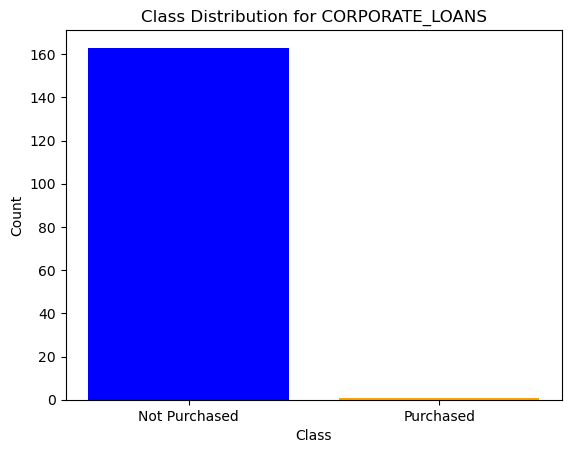

Class distribution for RETAIL_LOAN:
0    163
1      1
Name: RETAIL_LOAN, dtype: int64


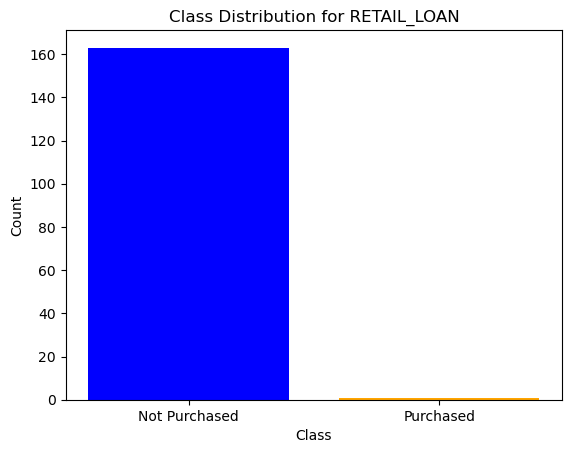

Class distribution for TRADE_SERVICES:
0    164
Name: TRADE_SERVICES, dtype: int64


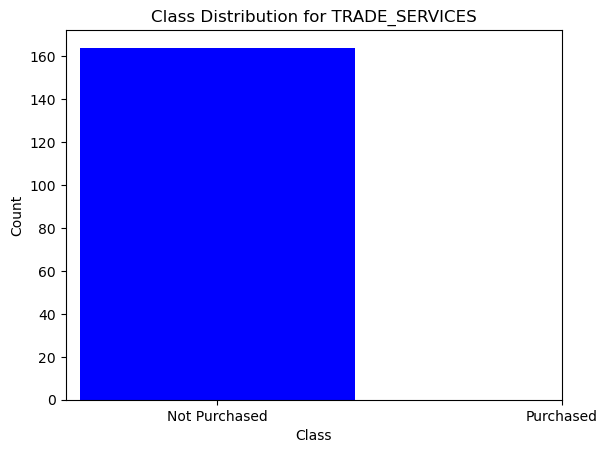

Class distribution for INVESTMENT_FUNDS:
0    164
Name: INVESTMENT_FUNDS, dtype: int64


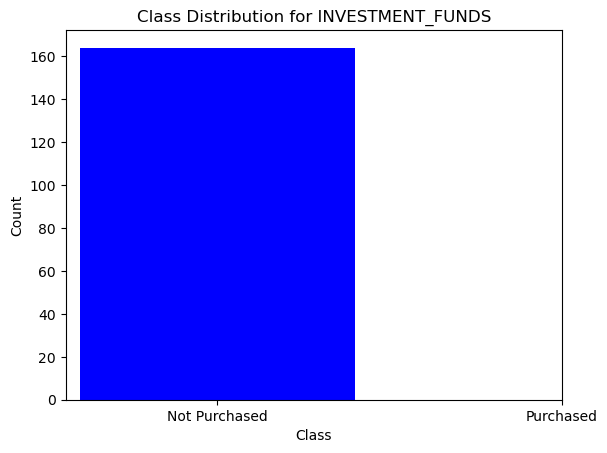

Class distribution for SECURITIES:
0    164
Name: SECURITIES, dtype: int64


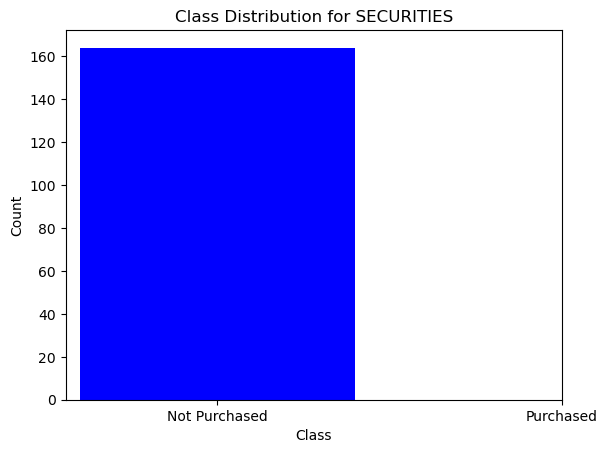

Class distribution for INSURANCE:
0    129
1     35
Name: INSURANCE, dtype: int64


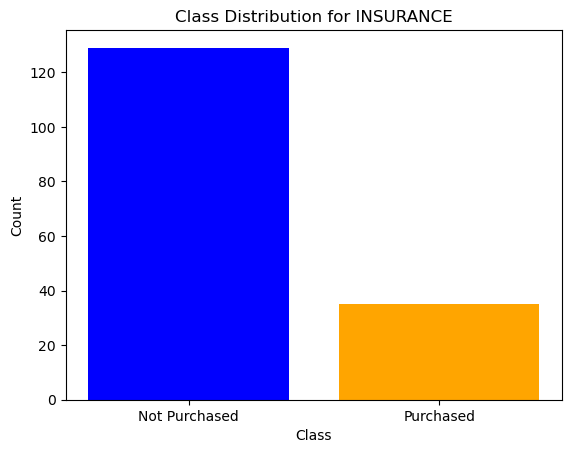

Class distribution for CORPORATE_FINANCE:
0    164
Name: CORPORATE_FINANCE, dtype: int64


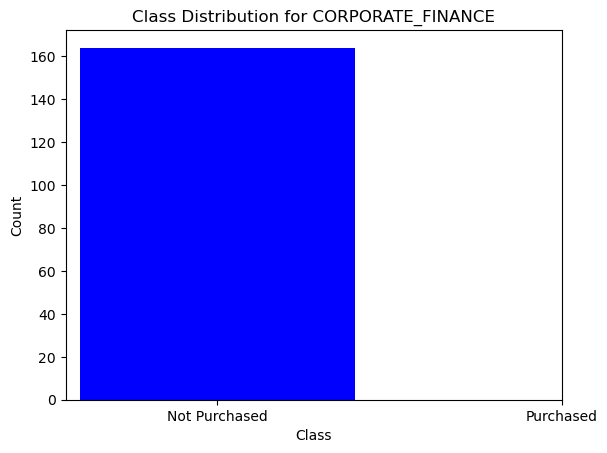

Class distribution for FOREX:
0    140
1     24
Name: FOREX, dtype: int64


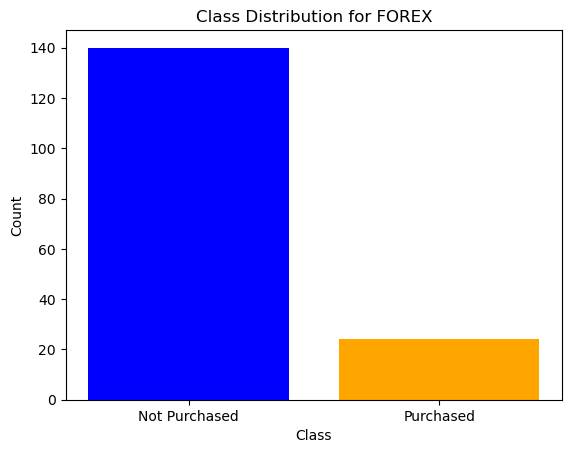

Class distribution for REMITTANCE:
0    164
Name: REMITTANCE, dtype: int64


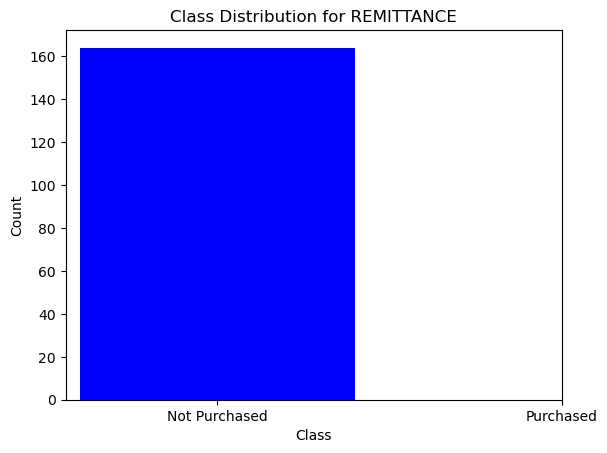

Class distribution for CORPORATE_CARDS:
0    163
1      1
Name: CORPORATE_CARDS, dtype: int64


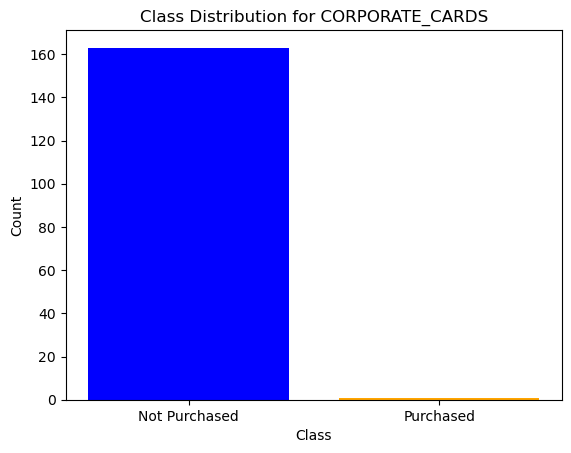

Class distribution for DEPOSITS:
1    163
0      1
Name: DEPOSITS, dtype: int64


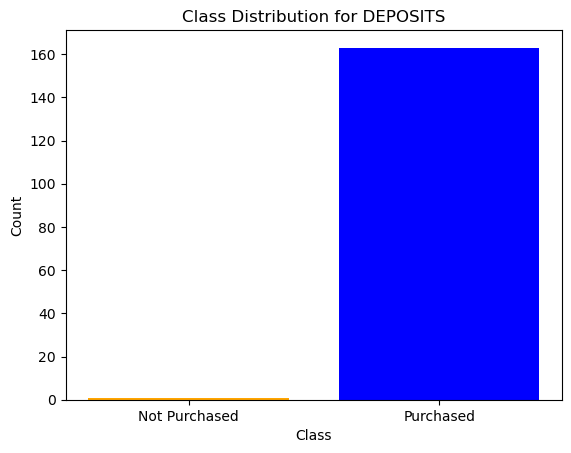

Class distribution for RETAIL_PRODUCTS:
1    90
0    74
Name: RETAIL_PRODUCTS, dtype: int64


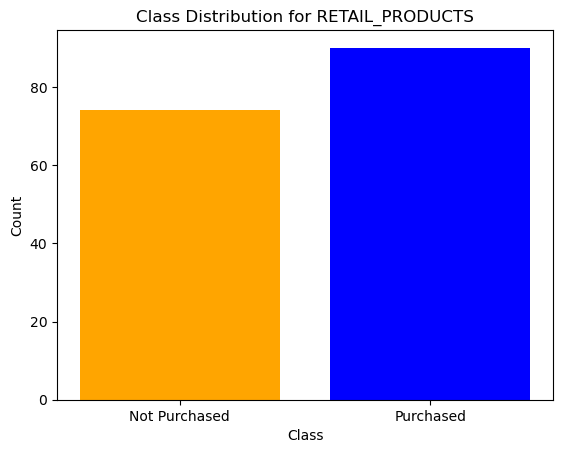

Class distribution for INVESTMENTS_AND_SECURITIES:
1    109
0     55
Name: INVESTMENTS_AND_SECURITIES, dtype: int64


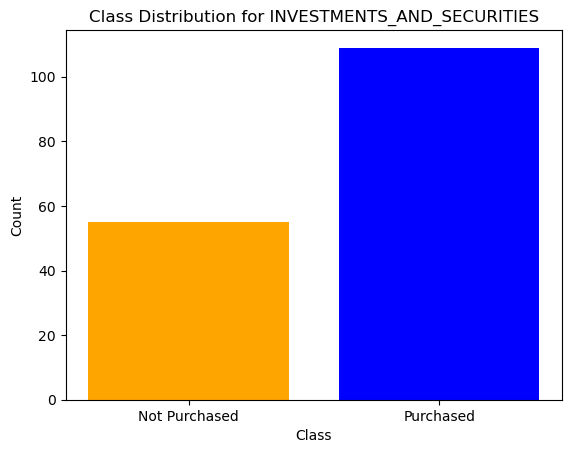

In [5]:
product_categories = ['CORPORATE_LOANS', 'RETAIL_LOAN', 'TRADE_SERVICES', 'INVESTMENT_FUNDS', 
                      'SECURITIES', 'INSURANCE', 'CORPORATE_FINANCE', 'FOREX', 
                      'REMITTANCE', 'CORPORATE_CARDS', 'DEPOSITS', 
                      'RETAIL_PRODUCTS', 'INVESTMENTS_AND_SECURITIES']

for target in product_categories:
    check_class_imbalance(merged_df, target)


Value counts for GENDER:
FEMALE    95
MALE      65
OTHERS     4
Name: GENDER, dtype: int64


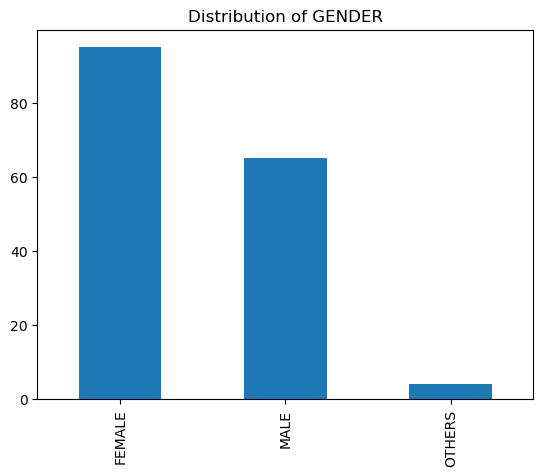


Value counts for MARITAL_STATUS:
SINGLE       93
MARRIED      61
WIDOWED       5
DIVORCED      3
SEPARATED     2
Name: MARITAL_STATUS, dtype: int64


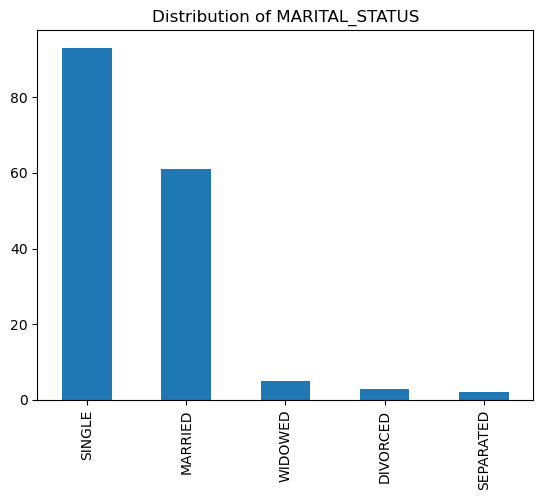


Value counts for EDUCATION:
MID        107
HIGH        38
NO_DATA     14
LOW          5
Name: EDUCATION, dtype: int64


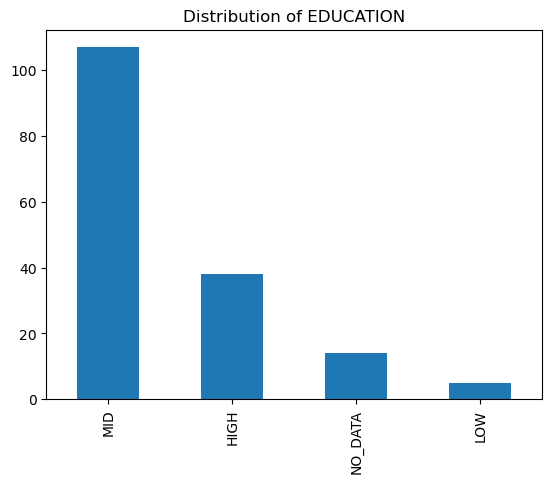


Value counts for INCOME_SOURCE:
SALARY                                     72
BUSINESS                                   36
INTEREST_SAVINGS_PLACEMENTS_INVESTMENTS    18
NO_DATA                                    15
PENSION                                    15
ALLOWANCE                                   6
REMITTANCE                                  1
COMMISSION                                  1
Name: INCOME_SOURCE, dtype: int64


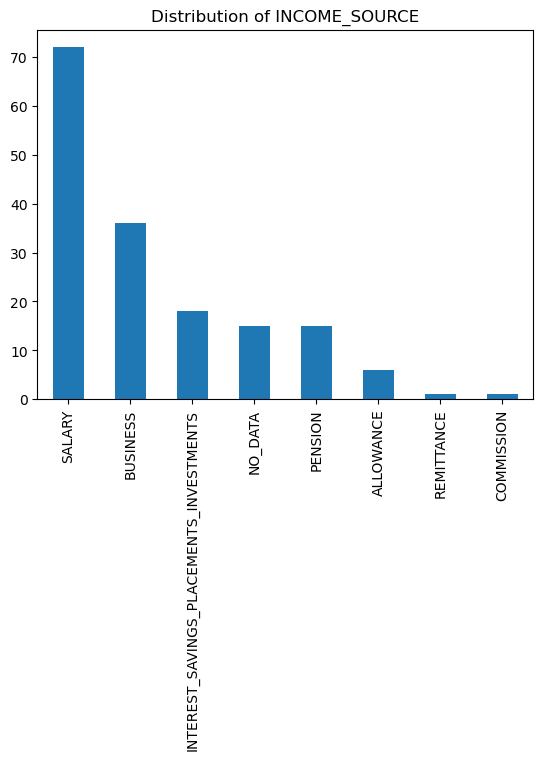


Value counts for BUSINESS_OWNER:
N    126
Y     38
Name: BUSINESS_OWNER, dtype: int64


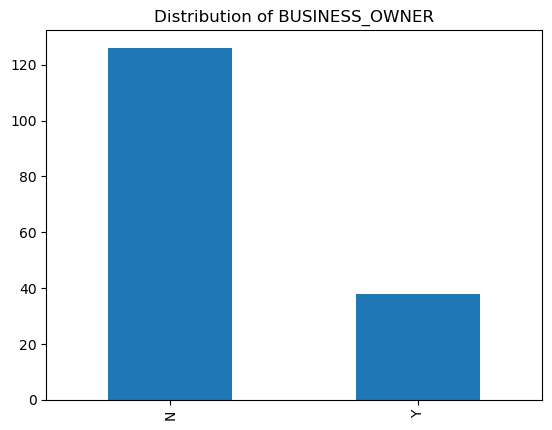


Value counts for PROVINCE:
NATIONAL CAPITAL REGION    126
CEBU                        10
NEGROS OCCIDENTAL            6
DAVAO DEL SUR                6
RIZAL                        3
CAVITE                       2
ZAMBOANGA DEL SUR            2
PAMPANGA                     1
ILOILO                       1
ILOCOS NORTE                 1
BATANGAS                     1
PANGASINAN                   1
ZAMBALES                     1
SOUTH COTABATO               1
NEGROS ORIENTAL              1
BUKIDNON                     1
Name: PROVINCE, dtype: int64


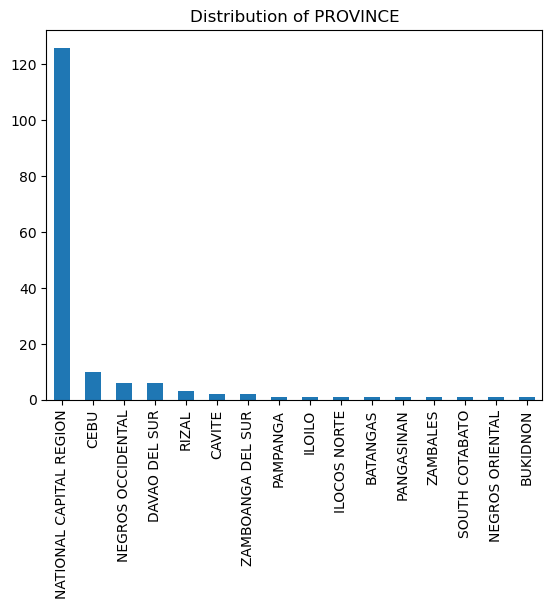


Value counts for REGION:
NATIONAL CAPITAL REGION            126
REGION VII (CENTRAL VISAYAS)        11
REGION VI (WESTERN VISAYAS)          7
REGION IV-A (CALABARZON)             6
REGION XI (DAVAO REGION)             6
REGION III (CENTRAL LUZON)           2
REGION I (ILOCOS REGION)             2
REGION IX (ZAMBOANGA PENINSULA)      2
REGION XII (SOCCSKSARGEN)            1
REGION X (NORTHERN MINDANAO)         1
Name: REGION, dtype: int64


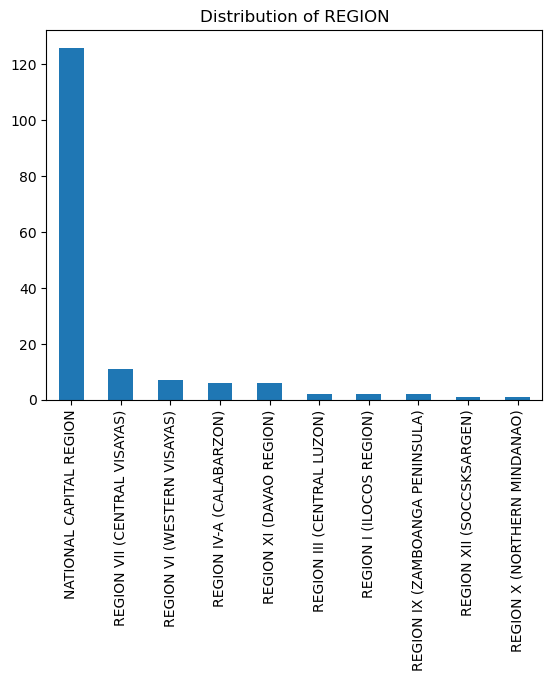


Value counts for SUBSEGMENT:
Top Tier    164
Name: SUBSEGMENT, dtype: int64


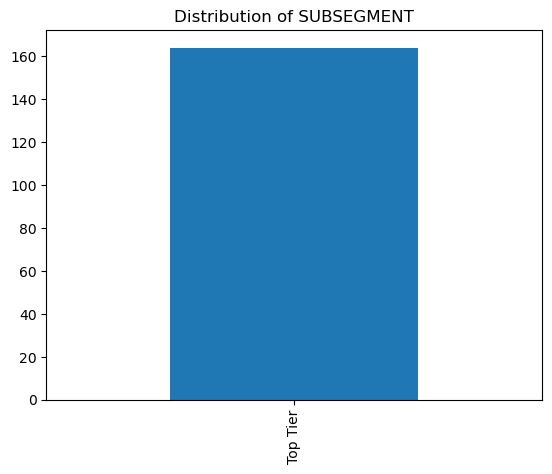

In [6]:
categorical_columns = ['GENDER', 'MARITAL_STATUS', 'EDUCATION', 'INCOME_SOURCE', 
                       'BUSINESS_OWNER', 'PROVINCE', 'REGION', 'SUBSEGMENT']
analyze_categorical_features(merged_df, categorical_columns)

Summary statistics for numerical features:
              AGE      TENURE
count  150.000000  164.000000
mean    62.860000   21.783077
std     16.014268    6.655148
min     25.000000    1.758904
25%     52.250000   20.508219
50%     64.000000   23.726027
75%     73.750000   26.334247
max    101.000000   31.145205


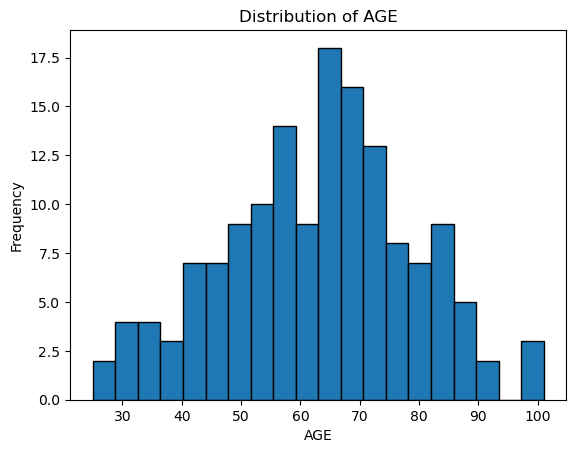

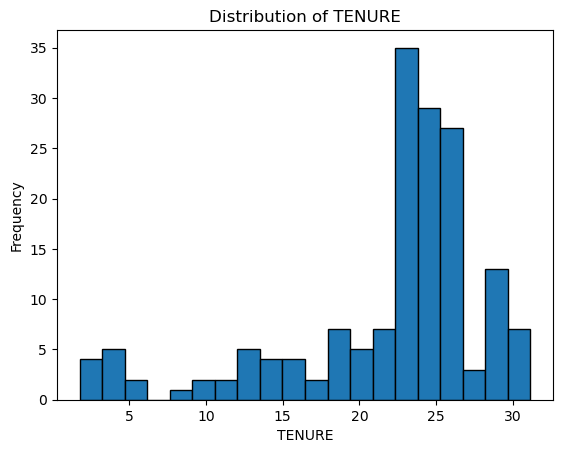

In [7]:
numerical_columns = ['AGE', 'TENURE']
analyze_numerical_features(merged_df, numerical_columns)

In [8]:
check_missing_values(merged_df)

Columns with missing values:
 AGE    14
dtype: int64


## Data Preprocessing

### Removing Null Values

In [9]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')
merged_df['AGE'] = imputer.fit_transform(merged_df[['AGE']])

/var/folders/jv/0sr2mpzx5klfxvmfj4s39_vm0000gn/T/ipykernel_20912/926605328.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['AGE'] = imputer.fit_transform(merged_df[['AGE']])


### Defining the Feature Matrix and Target Variable

In [10]:
target_product = 'INSURANCE'
X = merged_df.drop(columns=['CUST_NUM', target_product])  
y = merged_df[target_product] 

### One-Hot Encoding

In [11]:
categorical_columns = ['GENDER', 'MARITAL_STATUS', 'EDUCATION', 'INCOME_SOURCE', 
                       'BUSINESS_OWNER', 'PROVINCE', 'REGION', 'SUBSEGMENT', 'DIGITAL_FLAG']
X = pd.get_dummies(X, columns=categorical_columns, drop_first=True)

### Train Test Split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

### Smote to Handle Class Imbalance

In [13]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("Class distribution after SMOTE:")
print(pd.Series(y_train_resampled).value_counts())


Class distribution after SMOTE:
0    90
1    90
Name: INSURANCE, dtype: int64


## Model Training

In [14]:
xgb_model = XGBClassifier(random_state=42, eval_metric='logloss')
xgb_model.fit(X_train_resampled, y_train_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

## Model Validation

In [15]:
y_pred = xgb_model.predict(X_test)
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

roc_auc = roc_auc_score(y_test, y_pred_proba)
classification_report_output = classification_report(y_test, y_pred)

print(f"ROC-AUC Score: {roc_auc}")
print("Classification Report:")
print(classification_report_output)

ROC-AUC Score: 0.6107226107226107
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.79      0.78        39
           1       0.20      0.18      0.19        11

    accuracy                           0.66        50
   macro avg       0.49      0.49      0.49        50
weighted avg       0.65      0.66      0.65        50



In [16]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report
from imblearn.over_sampling import SMOTE

def train_xgboost_propensity_model(dataset, target_product, test_size=0.3, random_state=42, use_smote=True):
    X = dataset.drop(columns=['CUST_NUM', target_product])
    y = dataset[target_product]

    categorical_columns = ['GENDER', 'MARITAL_STATUS', 'EDUCATION', 'INCOME_SOURCE', 
                           'BUSINESS_OWNER', 'PROVINCE', 'REGION', 'SUBSEGMENT', 'DIGITAL_FLAG']
    X = pd.get_dummies(X, columns=categorical_columns, drop_first=True)

    # Check class distribution
    class_counts = y.value_counts()
    if len(class_counts) < 2 or class_counts.min() < 2:
        print(f"Skipping training for {target_product} as it contains a class with fewer than 2 instances.")
        return

    try:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, 
                                                            random_state=random_state, stratify=y)
    except ValueError as e:
        print(f"Falling back to non-stratified split for {target_product}: {e}")
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    if use_smote:
        smote = SMOTE(random_state=random_state)
        X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
        print("Class distribution after SMOTE:")
        print(pd.Series(y_train_resampled).value_counts())
    else:
        X_train_resampled, y_train_resampled = X_train, y_train

    xgb_model = XGBClassifier(random_state=random_state, eval_metric='logloss')
    xgb_model.fit(X_train_resampled, y_train_resampled)

    y_pred = xgb_model.predict(X_test)
    y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

    roc_auc = roc_auc_score(y_test, y_pred_proba)
    classification_report_output = classification_report(y_test, y_pred)
    
    print(f"ROC-AUC Score for {target_product}: {roc_auc}")
    print(f"Classification Report for {target_product}:")
    print(classification_report_output)

    # Plot feature importance
    plt.figure(figsize=(15, 10))
    plot_importance(xgb_model, importance_type='weight', max_num_features=None)
    plt.title(f"Feature Importance for {target_product}")
    plt.show()


Skipping training for CORPORATE_LOANS as it contains a class with fewer than 2 instances.
Skipping training for RETAIL_LOAN as it contains a class with fewer than 2 instances.
Skipping training for TRADE_SERVICES as it contains a class with fewer than 2 instances.
Skipping training for INVESTMENT_FUNDS as it contains a class with fewer than 2 instances.
Skipping training for SECURITIES as it contains a class with fewer than 2 instances.
ROC-AUC Score for INSURANCE: 0.627039627039627
Classification Report for INSURANCE:
              precision    recall  f1-score   support

           0       0.78      0.82      0.80        39
           1       0.22      0.18      0.20        11

    accuracy                           0.68        50
   macro avg       0.50      0.50      0.50        50
weighted avg       0.66      0.68      0.67        50



<Figure size 1500x1000 with 0 Axes>

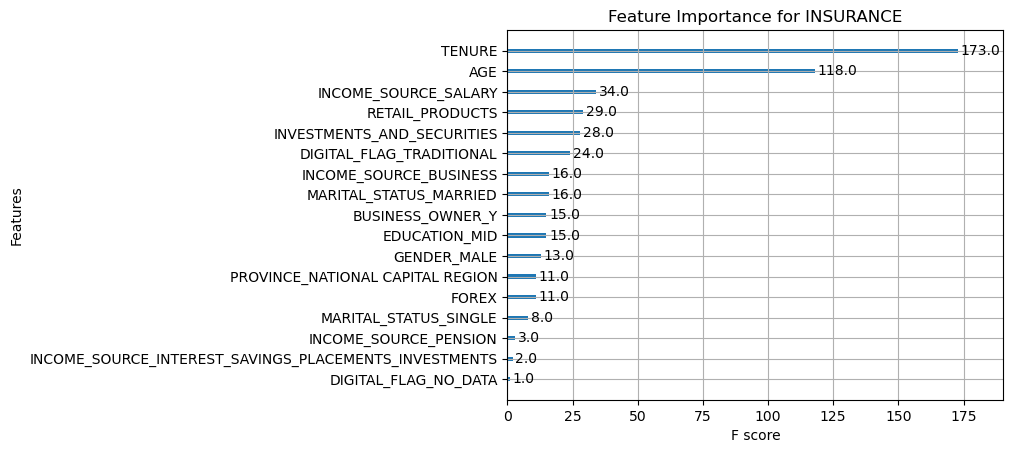

Skipping training for CORPORATE_FINANCE as it contains a class with fewer than 2 instances.
ROC-AUC Score for FOREX: 0.5514950166112956
Classification Report for FOREX:
              precision    recall  f1-score   support

           0       0.84      0.88      0.86        43
           1       0.00      0.00      0.00         7

    accuracy                           0.76        50
   macro avg       0.42      0.44      0.43        50
weighted avg       0.73      0.76      0.74        50



<Figure size 1500x1000 with 0 Axes>

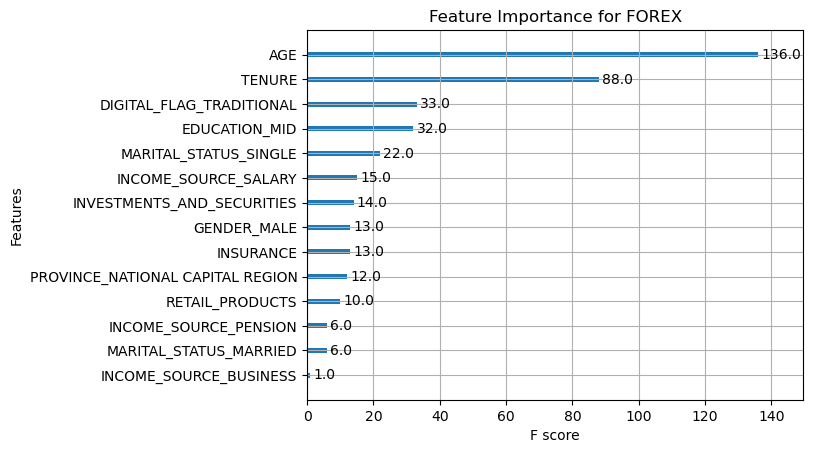

Skipping training for REMITTANCE as it contains a class with fewer than 2 instances.
Skipping training for CORPORATE_CARDS as it contains a class with fewer than 2 instances.
Skipping training for DEPOSITS as it contains a class with fewer than 2 instances.
ROC-AUC Score for RETAIL_PRODUCTS: 0.6441223832528181
Classification Report for RETAIL_PRODUCTS:
              precision    recall  f1-score   support

           0       0.58      0.48      0.52        23
           1       0.61      0.70      0.66        27

    accuracy                           0.60        50
   macro avg       0.60      0.59      0.59        50
weighted avg       0.60      0.60      0.59        50



<Figure size 1500x1000 with 0 Axes>

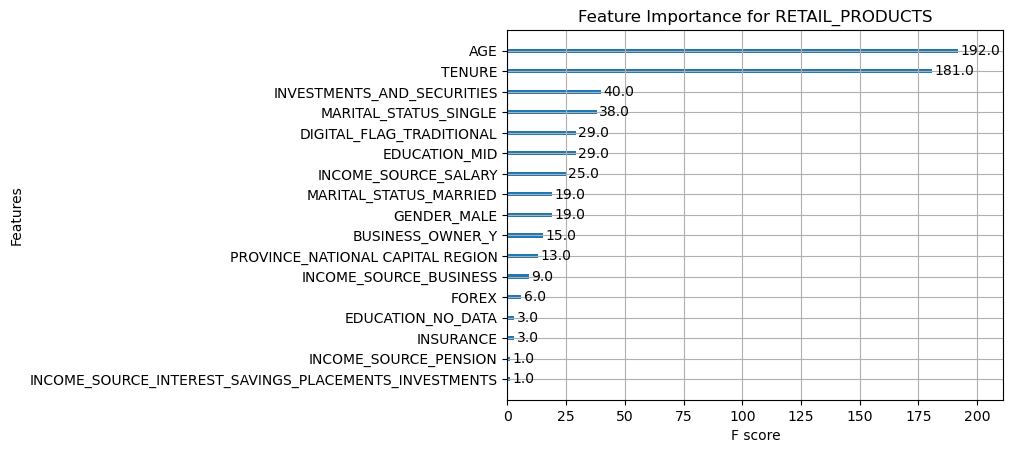

ROC-AUC Score for INVESTMENTS_AND_SECURITIES: 0.7040998217468806
Classification Report for INVESTMENTS_AND_SECURITIES:
              precision    recall  f1-score   support

           0       0.47      0.41      0.44        17
           1       0.71      0.76      0.74        33

    accuracy                           0.64        50
   macro avg       0.59      0.58      0.59        50
weighted avg       0.63      0.64      0.63        50



<Figure size 1500x1000 with 0 Axes>

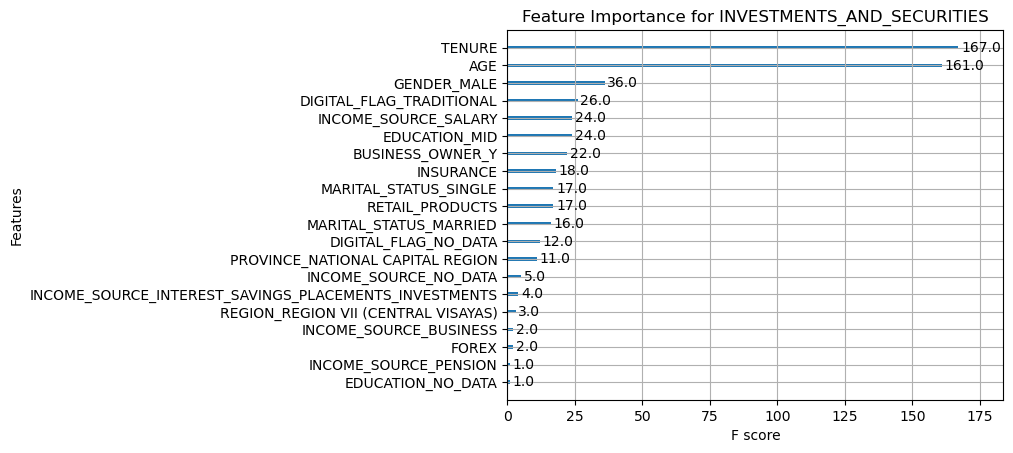

In [17]:
for i in product_categories:
    train_xgboost_propensity_model(
        dataset=merged_df,
        target_product= i,
        test_size=0.3,
        random_state=42,
        use_smote=False
    )

Skipping training for CORPORATE_LOANS as it contains a class with fewer than 2 instances.
Skipping training for RETAIL_LOAN as it contains a class with fewer than 2 instances.
Skipping training for TRADE_SERVICES as it contains a class with fewer than 2 instances.
Skipping training for INVESTMENT_FUNDS as it contains a class with fewer than 2 instances.
Skipping training for SECURITIES as it contains a class with fewer than 2 instances.
ROC-AUC Score for INSURANCE: 0.5524475524475524
Classification Report for INSURANCE:
              precision    recall  f1-score   support

           0       0.80      0.82      0.81        39
           1       0.30      0.27      0.29        11

    accuracy                           0.70        50
   macro avg       0.55      0.55      0.55        50
weighted avg       0.69      0.70      0.69        50



<Figure size 1500x1000 with 0 Axes>

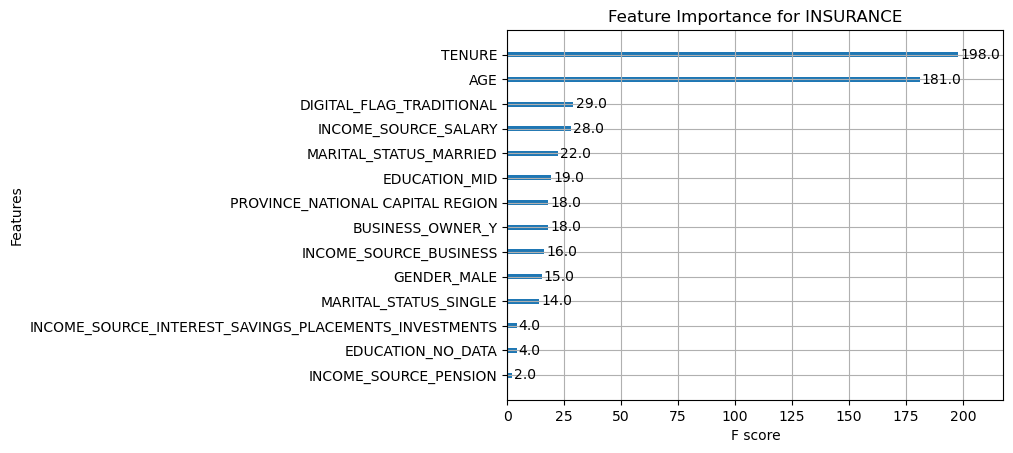

Skipping training for CORPORATE_FINANCE as it contains a class with fewer than 2 instances.
ROC-AUC Score for FOREX: 0.4983388704318937
Classification Report for FOREX:
              precision    recall  f1-score   support

           0       0.84      0.88      0.86        43
           1       0.00      0.00      0.00         7

    accuracy                           0.76        50
   macro avg       0.42      0.44      0.43        50
weighted avg       0.73      0.76      0.74        50



<Figure size 1500x1000 with 0 Axes>

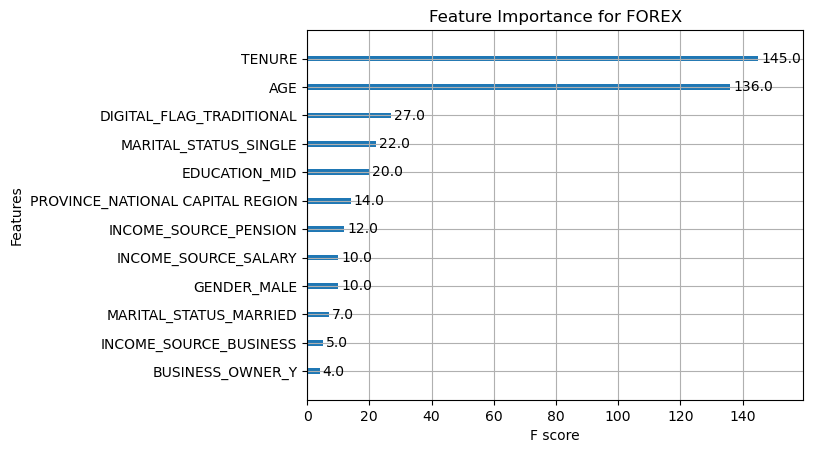

Skipping training for REMITTANCE as it contains a class with fewer than 2 instances.
Skipping training for CORPORATE_CARDS as it contains a class with fewer than 2 instances.
Skipping training for DEPOSITS as it contains a class with fewer than 2 instances.
ROC-AUC Score for RETAIL_PRODUCTS: 0.5974235104669887
Classification Report for RETAIL_PRODUCTS:
              precision    recall  f1-score   support

           0       0.55      0.48      0.51        23
           1       0.60      0.67      0.63        27

    accuracy                           0.58        50
   macro avg       0.57      0.57      0.57        50
weighted avg       0.58      0.58      0.58        50



<Figure size 1500x1000 with 0 Axes>

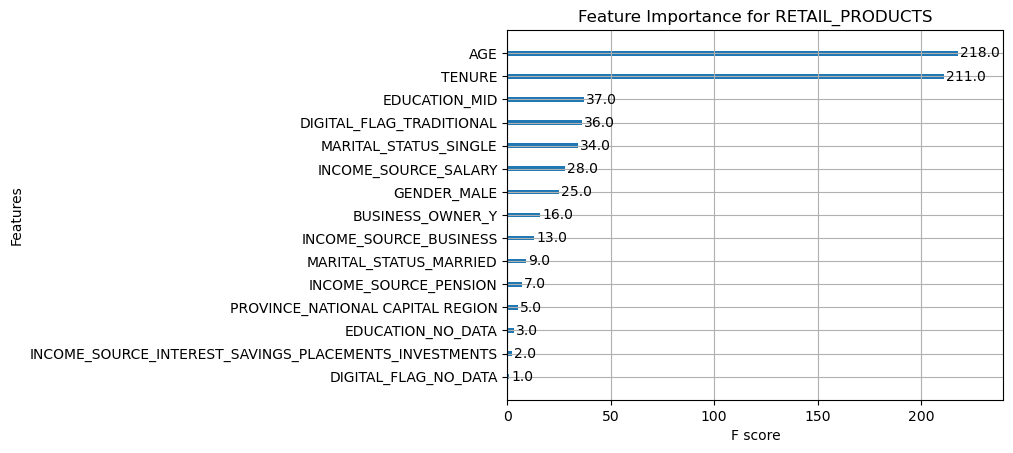

ROC-AUC Score for INVESTMENTS_AND_SECURITIES: 0.714795008912656
Classification Report for INVESTMENTS_AND_SECURITIES:
              precision    recall  f1-score   support

           0       0.53      0.47      0.50        17
           1       0.74      0.79      0.76        33

    accuracy                           0.68        50
   macro avg       0.64      0.63      0.63        50
weighted avg       0.67      0.68      0.67        50



<Figure size 1500x1000 with 0 Axes>

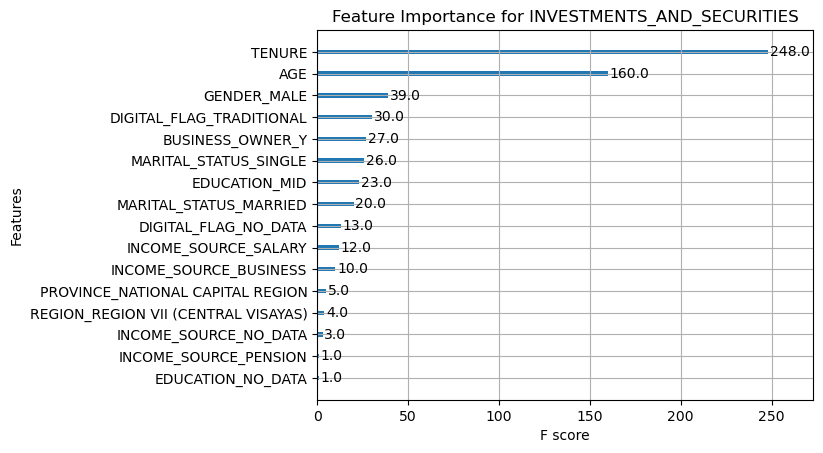

In [18]:
for i in product_categories:
    columns_to_drop = [col for col in product_categories if col != i]
    train_xgboost_propensity_model(
        dataset=merged_df.drop(columns=columns_to_drop),
        target_product=i,
        test_size=0.3,
        random_state=42,
        use_smote=False
    )


## Hyperparameter Tuning

In [19]:
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 300, 500],
    'scale_pos_weight': [1, len(y_train_resampled[y_train_resampled == 0]) / len(y_train_resampled[y_train_resampled == 1])],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1]
}

# Set up the XGBoost model
xgb_model = XGBClassifier(random_state=42, eval_metric='logloss')

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, 
                           scoring='roc_auc', cv=3, verbose=1, n_jobs=-1)

# Fit the model with the best hyperparameters
grid_search.fit(X_train_resampled, y_train_resampled)

# Retrieve the best model and its parameters
best_model = grid_search.best_estimator_
print(f"Best Hyperparameters: {grid_search.best_params_}")

# Predict on the test set using the best model
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Evaluate the model
roc_auc = roc_auc_score(y_test, y_pred_proba)
classification_report_output = classification_report(y_test, y_pred)

print(f"ROC-AUC Score: {roc_auc}")
print("Classification Report:")
print(classification_report_output)

Fitting 3 folds for each of 216 candidates, totalling 648 fits
Best Hyperparameters: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100, 'scale_pos_weight': 1, 'subsample': 1}
ROC-AUC Score: 0.5967365967365967
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.74      0.77        39
           1       0.29      0.36      0.32        11

    accuracy                           0.66        50
   macro avg       0.55      0.55      0.55        50
weighted avg       0.69      0.66      0.67        50

